In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import joblib

def manual_openfe_features(df_raw):
    df = df_raw.copy()

    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)

    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"] ),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"]),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"] ),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
         "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    
    return df_manual



df = pd.read_csv("train_cleaned_sex_binary.csv")  


y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors='ignore') 


X_manual = manual_openfe_features(X_raw)
X_final = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X_final = X_final.drop(columns=["Length", "Whole weight"], errors="ignore")


X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(xgb_objective, n_trials=100)


best_params = study.best_trial.params
print(" Best Parameters:", best_params)
print(" Best CV MSE:", -study.best_value)

best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_pred)
print("Final Test MSE:", final_mse)






[I 2025-05-26 15:56:41,562] A new study created in memory with name: no-name-c4b7f6d5-b0d4-4165-8ed3-8d92229e913f
[I 2025-05-26 15:56:45,326] Trial 0 finished with value: -3.27205228575978 and parameters: {'n_estimators': 437, 'learning_rate': 0.04522559872488704, 'gamma': 0.053117341264050766, 'reg_alpha': 0.5461950418511073, 'reg_lambda': 1.9975011956374336, 'max_depth': 7, 'min_child_weight': 3, 'subsample': 0.632743618589653, 'colsample_bytree': 0.9489985684795268}. Best is trial 0 with value: -3.27205228575978.
[I 2025-05-26 15:56:57,165] Trial 1 finished with value: -3.6998239271686293 and parameters: {'n_estimators': 393, 'learning_rate': 0.17647593026107394, 'gamma': 0.18796356868216202, 'reg_alpha': 0.4609065669215595, 'reg_lambda': 0.7466942537250278, 'max_depth': 16, 'min_child_weight': 10, 'subsample': 0.9005154084706355, 'colsample_bytree': 0.8779575122403502}. Best is trial 0 with value: -3.27205228575978.
[I 2025-05-26 15:57:01,064] Trial 2 finished with value: -3.645586

 Best Parameters: {'n_estimators': 356, 'learning_rate': 0.018194948712232005, 'gamma': 0.7310626310398153, 'reg_alpha': 0.6104786061859586, 'reg_lambda': 0.2070179647488289, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.6387193978287637, 'colsample_bytree': 0.6986522363402509}
 Best CV MSE: 3.2470418360439206
Final Test MSE: 3.2854699566009717


Train MSE: 2.3999, R²: 0.7458, RMSLE: 0.1299
Test MSE:  3.2855, R²: 0.6547, RMSLE: 0.1464


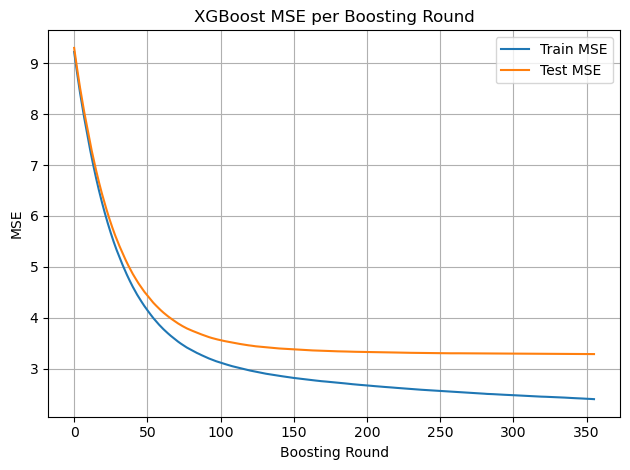

models/xgb_best_model.pkl


In [7]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from math import sqrt
import matplotlib.pyplot as plt
import joblib
import os

df = pd.read_csv("train_cleaned_sex_binary.csv")
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors='ignore')

def manual_openfe_features(df_raw):
    df = df_raw.copy()
    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)
    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / (df["Shell weight"]),
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / (df["Shell weight"]),
        "f03_Diameter_div_ShellWeight": df["Diameter"] / (df["Shell weight"]),
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    return df_manual

X_manual = manual_openfe_features(X_raw)
X_final = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X_final = X_final.drop(columns=["Length", "Whole weight"], errors="ignore")
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 356,
    'learning_rate': 0.018194948712232005,
    'gamma': 0.7310626310398153,
    'reg_alpha': 0.6104786061859586,
    'reg_lambda': 0.2070179647488289,
    'max_depth': 9,
    'min_child_weight': 8,
    'subsample': 0.6387193978287637,
    'colsample_bytree': 0.6986522363402509,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'n_jobs': -1
}

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

eval_result = xgb_model.evals_result()

train_rmse = np.array(eval_result['validation_0']['rmse'])
test_rmse = np.array(eval_result['validation_1']['rmse'])
train_mse = train_rmse ** 2
test_mse = test_rmse ** 2


y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

train_mse_final = mean_squared_error(y_train, y_train_pred)
test_mse_final = mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmsle = sqrt(mean_squared_log_error(y_train, np.maximum(0, y_train_pred)))
test_rmsle = sqrt(mean_squared_log_error(y_test, np.maximum(0, y_test_pred)))

print(f"Train MSE: {train_mse_final:.4f}, R²: {train_r2:.4f}, RMSLE: {train_rmsle:.4f}")
print(f"Test MSE:  {test_mse_final:.4f}, R²: {test_r2:.4f}, RMSLE: {test_rmsle:.4f}")

plt.plot(train_mse, label='Train MSE')
plt.plot(test_mse, label='Test MSE')
plt.xlabel("Boosting Round")
plt.ylabel("MSE")
plt.title("XGBoost MSE per Boosting Round")
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("xgboost_mse_plot.png", dpi=300)
plt.show()


joblib.dump(xgb_model, "xgb_best_model.pkl")
print("models/xgb_best_model.pkl")



